# Resonances of an aluminum cube

- Eigenmodes
- 3D
- Comparison with literature data

In [1]:
import numpy as np

from dolfinx import mesh, fem, default_scalar_type
from mpi4py import MPI
from petsc4py import PETSc

from elastodynamicsx.pde import material, PDE
from elastodynamicsx.solvers import EigenmodesSolver

### FE domain

In [2]:
L1, L2, L3 = 11.92, 10.93, 9.86  # Lengths, in millimeters
Nx = Ny = Nz = 6  # Nb of elts.
extent = [[0., 0., 0.], [L1, L2, L3]]
domain = mesh.create_box(MPI.COMM_WORLD, extent, [Nx, Ny, Nz])

V = fem.FunctionSpace(domain, ("Lagrange", 2, (domain.geometry.dim,)))

### Define the material law
Material:
- Aluminum
- isotropic elasticity

Units:
- $\rho$ in g/cm3
- $C_{ij}$ in GPa
- -> frequencies in MHz

In [3]:
rho, C11, C44 = 2.788, 109.26, 26.72
lambda_ = C11 - 2 * C44
mu      = C44
rho     = fem.Constant(domain, default_scalar_type(rho))
lambda_ = fem.Constant(domain, default_scalar_type(lambda_))
mu      = fem.Constant(domain, default_scalar_type(mu))

aluminum = material(V, 'isotropic', rho, lambda_, mu)

### Assemble the PDE

In [4]:
pde = PDE(V, materials=[aluminum])

### Solve

In [5]:
# ## Initialize the solver; prepare to solve for 20 eigenvalues
M = pde.M()  # mass matrix (PETSc)
C = None  # None to ensure no damping
K = pde.K()  # stiffness matrix (PETSc)
eps = EigenmodesSolver(V.mesh.comm, M, C, K, nev=20)

In [6]:
# ## Run the big calculation!
eps.solve()
# ## End of big calc.

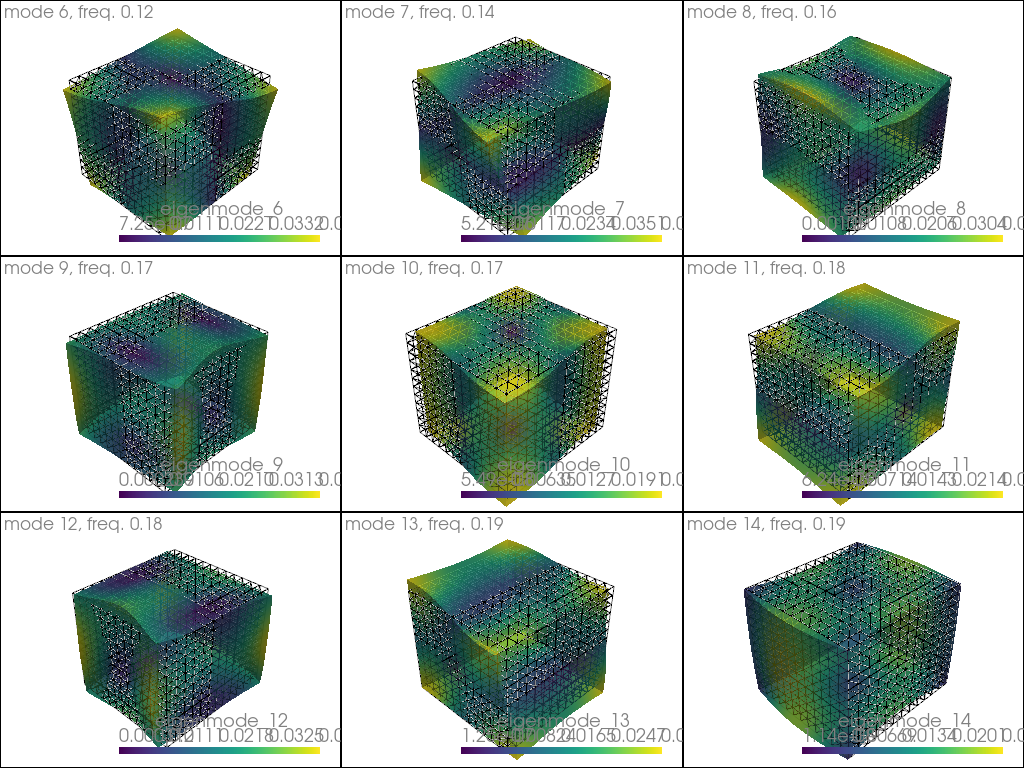

In [7]:
# ## Get the result
# eps.printEigenvalues()
eigenfreqs = eps.getEigenfrequencies()
# eigenmodes = eps.getEigenmodes()

eps.plot(V, slice(6,6+9), wireframe=True, factor=30)  # Avoid the first 6 rigid body modes

### Compare with literature values
-----------------------------------------------------
Data from:  
&emsp; Ogi, H., Sato, K., Asada, T., & Hirao, M. (2002). Complete mode
identification for resonance ultrasound spectroscopy. *The Journal of the
Acoustical Society of America*, 112(6), 2553-2557.

In [8]:
freqs_OgiEtAl_exp  = np.array([116.716, 143.783, 158.081, 166.5  , 169.523, 177.846, 183.875, 186.047,
                               190.341, 197.386, 201.133, 207.386, 209.836, 214.753, 223.548, 231.266,
                               233.538, 234.717, 250.98 , 251.256, 252.742, 256.122, 257.595, 258.118,
                               259.035, 268.54 , 277.113, 278.762, 282.311, 293.686, 293.686, 293.686,
                               310.109, 316.197, 317.392, 326.462, 329.034, 332.441, 333.364, 336.65,
                               337.359, 338.276])

freqs_OgiEtAl_calc = np.array([116.32 , 143.186, 158.44 , 166.113, 169.338, 178.36 , 184.57 , 185.078, \
                               190.206, 197.692, 201.462, 207.096, 211    , 215.613, 223.219, 230.804, \
                               233.329, 234.758, 250.777, 251.038, 252.303, 256.849, 258.064, 258.874, \
                               259.203, 267.746, 276.736, 279.144, 282.773, 293.016, 304.593, 305.316, \
                               309.591, 315.775, 317.931, 326.556, 329.369, 332.732, 332.271, 336.218, \
                               337.511, 337.71])

print('Eigenfrequencies: comparison with litterature values')
print('  FE   \tOgi et al, calc.\t Ogi et al, exp. \t(kHz)')
for fFE, fOgi_calc, fOgi_exp in zip(eigenfreqs[6:]*1e3, freqs_OgiEtAl_calc, freqs_OgiEtAl_exp):  # *1e3 to convert MHz into kHz
    print(str(round(fFE, 3)) +"\t     "+ str(round(fOgi_calc, 3)) +"\t\t     "+ str(round(fOgi_exp, 3)))

Eigenfrequencies: comparison with litterature values
  FE   	Ogi et al, calc.	 Ogi et al, exp. 	(kHz)
116.414	     116.32		     116.716
143.605	     143.186		     143.783
158.517	     158.44		     158.081
166.27	     166.113		     166.5
169.457	     169.338		     169.523
178.607	     178.36		     177.846
184.935	     184.57		     183.875
185.384	     185.078		     186.047
190.293	     190.206		     190.341
198.003	     197.692		     197.386
202.098	     201.462		     201.133
207.531	     207.096		     207.386
211.323	     211.0		     209.836
216.115	     215.613		     214.753
